In [1]:
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from synthetic_solver import *
plt.rcParams.update({'font.size': 15, 'lines.linewidth':3.5})

## Prep Data

In [2]:
rand_seed = 42
# init params
num_theta_to_search = 500
diff_bound = 0.01
N = 100000      # total num
p_a = 0.8       # group a ratio
p_b = 1 - p_a   # group b ratio
alpha_a = 0.8   # group a qualification rate
alpha_b = 0.3   # group b qualification rate
u_plus = 1      # u+
u_minus = 10    # u-
mu_a_0 = 50     # feature distr params
sigma_a_0 = 10
mu_a_1 = 70
sigma_a_1 = 10
mu_b_0 = 50
sigma_b_0 = 10
mu_b_1 = 70
sigma_b_1 = 10

In [3]:
# sample feature val from distr
np.random.seed(rand_seed)
num_a_1 = int(N * p_a * alpha_a)
num_a_0 = int(N * p_a * (1 - alpha_a))
num_b_1 = int(N * p_b * alpha_b)
num_b_0 = int(N * p_b * (1 - alpha_b))
num_a = num_a_0 + num_a_1
num_b = num_b_0 + num_b_1
X_a_0 = np.sort(np.random.normal(mu_a_0, sigma_a_0, num_a_0))
X_a_1 = np.sort(np.random.normal(mu_a_1, sigma_a_1, num_a_1))
X_b_0 = np.sort(np.random.normal(mu_b_0, sigma_b_0, num_b_0))
X_b_1 = np.sort(np.random.normal(mu_b_1, sigma_b_1, num_b_1))
X_min = min(np.min(X_a_0), np.min(X_a_1), np.min(X_b_0), np.min(X_b_1))
X_max = max(np.max(X_a_0), np.max(X_a_1), np.max(X_b_0), np.max(X_b_1))
theta_list = np.linspace(X_min, X_max, num_theta_to_search)
theta_list = np.append(np.array(theta_list[0]-1), theta_list) # add a smaller theta for edge case

## Find Curves

### Unbiased

In [4]:
util_total_list = np.full((len(theta_list), len(theta_list)), -np.inf)
select_a_list = np.full((len(theta_list), len(theta_list)), -np.inf)
select_b_list = np.full((len(theta_list), len(theta_list)), -np.inf)
select_b_given_a_DP = np.full(len(theta_list), -np.inf)
select_b_given_a_TP = np.full(len(theta_list), -np.inf)
select_b_given_a_FP = np.full(len(theta_list), -np.inf)
select_b_given_a_EO = np.full(len(theta_list), -np.inf)
select_b_given_a_ER = np.full(len(theta_list), -np.inf)
util_total_DP_list = np.full(len(theta_list), -np.inf)
util_total_TP_list = np.full(len(theta_list), -np.inf)
util_total_FP_list = np.full(len(theta_list), -np.inf)
util_total_EO_list = np.full(len(theta_list), -np.inf)
util_total_ER_list = np.full(len(theta_list), -np.inf)
for i in range(len(theta_list)):
    if i % 50 == 0:
        print('{}/{}'.format(i, len(theta_list)), end=', ')
    theta_a = theta_list[i]
    select_a = (np.sum(X_a_0 > theta_a) + np.sum(X_a_1 > theta_a)) / num_a
    FP_a = np.sum(X_a_0 > theta_a) / num_a_0
    TP_a = np.sum(X_a_1 > theta_a) / num_a_1
    min_DP_diff = np.inf
    min_TP_diff = np.inf
    min_FP_diff = np.inf
    min_EO_diff = np.inf
    for j in range(len(theta_list)):
        theta_b = theta_list[j]
        select_b = (np.sum(X_b_0 > theta_b) + np.sum(X_b_1 > theta_b)) / num_b
        TP_b = np.sum(X_b_1 > theta_b) / num_b_1
        FP_b = np.sum(X_b_0 > theta_b) / num_b_0
        ER_b = (np.sum(X_b_0 > theta_b) + np.sum(X_b_1 <= theta_b)) / num_b
        select_a_list[i,j] = select_a
        select_b_list[i,j] = select_b
        util_total_list[i,j] = sum(get_util(theta_a, theta_b, X_a_0, X_a_1, X_b_0, X_b_1, u_plus, u_minus))
        # DP
        DP_diff = abs(select_a - select_b)
        if DP_diff < min_DP_diff and DP_diff < diff_bound:
            min_DP_diff = DP_diff
            select_b_given_a_DP[i] = select_b
            util_total_DP_list[i] = util_total_list[i,j]
        # TP
        TP_diff = abs(TP_a - TP_b)
        if TP_diff < min_TP_diff and TP_diff < diff_bound:
            min_TP_diff = TP_diff
            select_b_given_a_TP[i] = select_b
            util_total_TP_list[i] = util_total_list[i,j]
        # FP
        FP_diff = abs(FP_a - FP_b)
        if FP_diff < min_FP_diff and FP_diff < diff_bound:
            min_FP_diff = FP_diff
            select_b_given_a_FP[i] = select_b
            util_total_FP_list[i] = util_total_list[i,j]
        # EO
        EO_diff = max(TP_diff, FP_diff)
        if EO_diff < min_EO_diff and EO_diff < diff_bound:
            min_EO_diff = EO_diff
            select_b_given_a_EO[i] = select_b
            util_total_EO_list[i] = util_total_list[i,j]

0/501, 50/501, 100/501, 150/501, 200/501, 250/501, 300/501, 350/501, 400/501, 450/501, 500/501, 

### Biased

In [5]:
np.random.seed(rand_seed)
p = 0.2
# label bias
ind_sampled = np.random.choice(len(X_b_1), int(len(X_b_1)*p))
X_b_0_biased = np.sort(np.append(X_b_1[ind_sampled], X_b_0)) # move p% of X_b_1 to X_b_0
X_b_1_biased = np.delete(X_b_1, ind_sampled) # delete those p% from X_b_1

X_min_biased = min(np.min(X_a_0), np.min(X_a_1), np.min(X_b_0_biased), np.min(X_b_1_biased))
X_max_biased = max(np.max(X_a_0), np.max(X_a_1), np.max(X_b_0_biased), np.max(X_b_1_biased))
theta_list_biased = np.linspace(X_min_biased, X_max_biased, num_theta_to_search)
theta_list_biased = np.append(np.array(theta_list_biased[0]-1), theta_list_biased) # add a smaller theta for edge case

util_total_list_biased = np.full((len(theta_list_biased), len(theta_list_biased)), -np.inf)
select_a_list_biased = np.full((len(theta_list_biased), len(theta_list_biased)), -np.inf)
select_b_list_biased = np.full((len(theta_list_biased), len(theta_list_biased)), -np.inf)
select_b_given_a_DP_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_TP_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_FP_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_EO_biased = np.full(len(theta_list_biased), -np.inf)
util_total_DP_list_biased = np.full(len(theta_list_biased), -np.inf)
util_total_TP_list_biased = np.full(len(theta_list_biased), -np.inf)
util_total_FP_list_biased = np.full(len(theta_list_biased), -np.inf)
util_total_EO_list_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_on_unbiased_DP_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_on_unbiased_TP_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_on_unbiased_FP_biased = np.full(len(theta_list_biased), -np.inf)
select_b_given_a_on_unbiased_EO_biased = np.full(len(theta_list_biased), -np.inf)
for i in range(len(theta_list_biased)):
    if i % 50 == 0:
        print('{}/{}'.format(i, len(theta_list_biased)), end=', ')
    theta_a_biased = theta_list_biased[i]
    select_a_biased = (np.sum(X_a_0 > theta_a_biased) + np.sum(X_a_1 > theta_a_biased)) / num_a
    FP_a_biased = np.sum(X_a_0 > theta_a_biased) / num_a_0
    TP_a_biased = np.sum(X_a_1 > theta_a_biased) / num_a_1
    min_DP_diff_biased = np.inf
    min_TP_diff_biased = np.inf
    min_FP_diff_biased = np.inf
    min_EO_diff_biased = np.inf
    for j in range(len(theta_list_biased)):
        theta_b_biased = theta_list_biased[j]
        select_b_biased = (np.sum(X_b_0_biased > theta_b_biased) + np.sum(X_b_1_biased > theta_b_biased)) \
                            / (len(X_b_0_biased)+len(X_b_1_biased))
        TP_b_biased = np.sum(X_b_1_biased > theta_b_biased) / len(X_b_1_biased)
        FP_b_biased = np.sum(X_b_0_biased > theta_b_biased) / len(X_b_0_biased)
        ER_b_biased = (np.sum(X_b_0_biased > theta_b_biased) + np.sum(X_b_1_biased <= theta_b_biased)) / num_b
        select_a_list_biased[i,j] = select_a_biased
        select_b_list_biased[i,j] = select_b_biased
        util_total_list_biased[i,j] = \
            sum(get_util(theta_a_biased, theta_b_biased, X_a_0, X_a_1, X_b_0_biased, X_b_1_biased, u_plus, u_minus))
        # DP
        DP_diff_biased = abs(select_a_biased - select_b_biased)
        if DP_diff_biased < min_DP_diff_biased and DP_diff_biased < diff_bound:
            min_DP_diff_biased = DP_diff_biased
            select_b_given_a_DP_biased[i] = select_b_biased
            select_b_given_a_on_unbiased_DP_biased[i] = \
                (np.sum(X_b_0 > theta_b_biased) + np.sum(X_b_1 > theta_b_biased)) / (len(X_b_0)+len(X_b_1))
            util_total_DP_list_biased[i] = util_total_list_biased[i,j]
        # TP
        TP_diff_biased = abs(TP_a_biased - TP_b_biased)
        if TP_diff_biased < min_TP_diff_biased and TP_diff_biased < diff_bound:
            min_TP_diff_biased = TP_diff_biased
            select_b_given_a_TP_biased[i] = select_b_biased
            select_b_given_a_on_unbiased_TP_biased[i] = \
                (np.sum(X_b_0 > theta_b_biased) + np.sum(X_b_1 > theta_b_biased)) / (len(X_b_0)+len(X_b_1))
            util_total_TP_list_biased[i] = util_total_list_biased[i,j]
        # FP
        FP_diff_biased = abs(FP_a_biased - FP_b_biased)
        if FP_diff_biased < min_FP_diff_biased and FP_diff_biased < diff_bound:
            min_FP_diff_biased = FP_diff_biased
            select_b_given_a_FP_biased[i] = select_b_biased
            select_b_given_a_on_unbiased_FP_biased[i] = \
                (np.sum(X_b_0 > theta_b_biased) + np.sum(X_b_1 > theta_b_biased)) / (len(X_b_0)+len(X_b_1))
            util_total_FP_list_biased[i] = util_total_list_biased[i,j]
        # EO
        EO_diff_biased = max(TP_diff_biased, FP_diff_biased)
        if EO_diff_biased < min_EO_diff_biased and EO_diff_biased < diff_bound:
            min_EO_diff_biased = EO_diff_biased
            select_b_given_a_EO_biased[i] = select_b_biased
            select_b_given_a_on_unbiased_EO_biased[i] = \
                (np.sum(X_b_0 > theta_b_biased) + np.sum(X_b_1 > theta_b_biased)) / (len(X_b_0)+len(X_b_1))
            util_total_EO_list_biased[i] = util_total_list_biased[i,j]

0/501, 50/501, 100/501, 150/501, 200/501, 250/501, 300/501, 350/501, 400/501, 450/501, 500/501, 

## Visualize

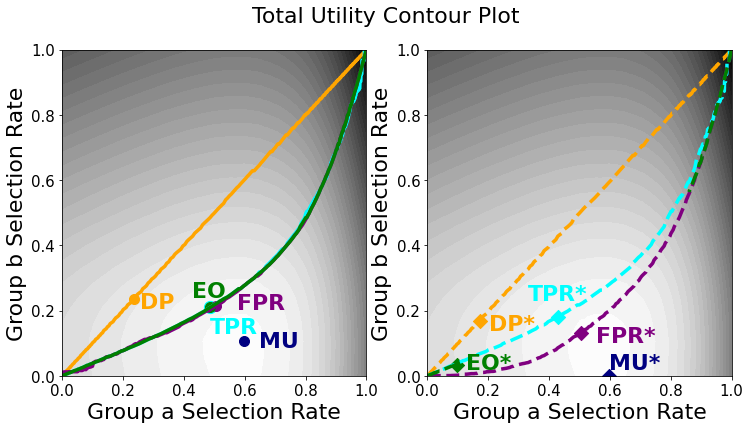

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
fs = 22
ax[0].contourf(select_a_list, select_b_list, util_total_list, cmap='gist_gray', levels=40)
ax[1].contourf(select_a_list, select_b_list, util_total_list, cmap='gist_gray', levels=40)
# MU
MU_ind = np.unravel_index(np.argmax(util_total_list), util_total_list.shape)
ax[0].scatter(select_a_list[MU_ind[0],0], select_b_list[0, MU_ind[1]], s=100, c='navy')
ax[0].annotate('MU', xy=(select_a_list[MU_ind[0],0]+0.05, select_b_list[0, MU_ind[1]]-0.02), c='navy', fontweight='bold', fontsize=fs)
# DP
DP_ind = np.argmax(util_total_DP_list)
ax[0].scatter(select_a_list[DP_ind, 0], select_b_given_a_DP[DP_ind], s=100, c='orange')
ax[0].plot(select_a_list[:, 0], select_b_given_a_DP, c='orange')
ax[0].annotate('DP', xy=(select_a_list[DP_ind,0]+0.02, select_b_given_a_DP[DP_ind]-0.03), c='orange', fontweight='bold', fontsize=fs)
# TP
TP_ind = np.argmax(util_total_TP_list)
ax[0].scatter(select_a_list[TP_ind, 0], select_b_given_a_TP[TP_ind], s=150, c='cyan')
ax[0].plot(select_a_list[:, 0], select_b_given_a_TP, c='cyan')
ax[0].annotate('TPR', xy=(select_a_list[TP_ind,0], select_b_given_a_TP[TP_ind]-0.08), c='cyan', fontweight='bold', fontsize=fs)
# FP
FP_ind = np.argmax(util_total_FP_list)
ax[0].scatter(select_a_list[FP_ind, 0], select_b_given_a_FP[FP_ind], s=100, c='purple')
ax[0].plot(select_a_list[:, 0], select_b_given_a_FP, c='purple')
ax[0].annotate('FPR', xy=(select_a_list[FP_ind,0]+0.07, select_b_given_a_FP[FP_ind]-0.01), c='purple', fontweight='bold', fontsize=fs)
# EO
EO_ind = np.argmax(util_total_EO_list)
ax[0].scatter(select_a_list[EO_ind, 0], select_b_given_a_EO[EO_ind], s=100, c='green')
ax[0].plot(select_a_list[:, 0], select_b_given_a_EO, c='green')
ax[0].annotate('EO', xy=(select_a_list[EO_ind,0]-0.06, select_b_given_a_EO[EO_ind]+0.03), c='green', fontweight='bold', fontsize=fs)
''' biased '''
# MU
MU_ind_biased = np.unravel_index(np.argmax(util_total_list_biased), util_total_list_biased.shape)
theta_b_biased = theta_list_biased[MU_ind_biased[1]]
select_b_MU_biased = (np.sum(X_b_0 > theta_b_biased)+np.sum(X_b_1 > theta_b_biased)) / (len(X_b_0)+len(X_b_1))
ax[1].scatter(select_a_list_biased[MU_ind_biased[0],0], select_b_MU_biased, s=100, c='navy', marker='D')
ax[1].annotate('MU*', xy=(select_a_list_biased[MU_ind_biased[0],0], select_b_MU_biased+0.02), c='navy', fontweight='bold', fontsize=fs)
# DP
DP_ind_biased = np.argmax(util_total_DP_list_biased)
ax[1].plot(select_a_list_biased[:, 0], select_b_given_a_on_unbiased_DP_biased, c='orange', linestyle='dashed')
ax[1].scatter(select_a_list_biased[DP_ind_biased, 0], select_b_given_a_on_unbiased_DP_biased[DP_ind_biased], s=100, c='orange', marker='D')
ax[1].annotate('DP*', xy=(select_a_list_biased[DP_ind_biased,0]+0.03, select_b_given_a_on_unbiased_DP_biased[DP_ind_biased]-0.03), 
    c='orange', fontweight='bold', fontsize=fs)
# TP
TP_ind_biased = np.argmax(util_total_TP_list_biased)
ax[1].plot(select_a_list_biased[:, 0], select_b_given_a_on_unbiased_TP_biased, c='cyan', linestyle='dashed')
ax[1].scatter(select_a_list_biased[TP_ind_biased, 0], select_b_given_a_on_unbiased_TP_biased[TP_ind_biased], s=100, c='cyan', marker='D')
ax[1].annotate('TPR*', xy=(select_a_list_biased[TP_ind_biased,0]-0.1, select_b_given_a_on_unbiased_TP_biased[TP_ind_biased]+0.05), 
    c='cyan', fontweight='bold', fontsize=fs)
# FP
FP_ind_biased = np.argmax(util_total_FP_list_biased)
ax[1].plot(select_a_list_biased[:, 0], select_b_given_a_on_unbiased_FP_biased, c='purple', linestyle='dashed')
ax[1].scatter(select_a_list_biased[FP_ind_biased, 0], select_b_given_a_on_unbiased_FP_biased[FP_ind_biased], s=100, c='purple', marker='D')
ax[1].annotate('FPR*', xy=(select_a_list_biased[FP_ind_biased,0]+0.05, select_b_given_a_on_unbiased_FP_biased[FP_ind_biased]-0.03), 
    c='purple', fontweight='bold', fontsize=fs)
# EO
EO_ind_biased = np.argmax(util_total_EO_list_biased)
ax[1].plot(select_a_list_biased[:, 0], select_b_given_a_on_unbiased_EO_biased, c='green', linestyle='dashed')
ax[1].scatter(select_a_list_biased[EO_ind_biased, 0], select_b_given_a_on_unbiased_EO_biased[EO_ind_biased], s=100, c='green', marker='D')
ax[1].annotate('EO*', xy=(select_a_list_biased[EO_ind_biased,0]+0.03, select_b_given_a_on_unbiased_EO_biased[EO_ind_biased]-0.015), 
    c='green', fontweight='bold', fontsize=fs)
ax[0].set_xlabel('Group a Selection Rate', fontsize=fs)
ax[0].set_ylabel('Group b Selection Rate', fontsize=fs)
ax[1].set_xlabel('Group a Selection Rate', fontsize=fs)
ax[1].set_ylabel('Group b Selection Rate', fontsize=fs)
plt.suptitle('Total Utility Contour Plot'.format(u_plus, u_minus), fontsize=fs)
plt.show()